In [26]:
import pandas as pd
import numpy as np
import psycopg2.extras as extras
from datetime import datetime, timedelta
import psycopg2
import pandas.io.sql as sqlio
from database_mapper.config import config
import matplotlib.pyplot as plt
from scipy import stats

params = config()

conn = psycopg2.connect(**params)
conn.autocommit = True
cursor = conn.cursor()


train_df = sqlio.read_sql_query("SELECT * FROM traindelays3   order by planned_departure", conn)
weather_df = sqlio.read_sql_query("SELECT * FROM weather_details4", conn)



In [27]:
train_df['delay_in_seconds'] = train_df['delay'] / np.timedelta64(1, 's')
train_df['planned_departure'] = pd.to_datetime(train_df['planned_departure'])
train_df['planned_departure_day'] = train_df['planned_departure'].dt.day
train_df['planned_departure_hour'] = train_df['planned_departure'].dt.hour
train_df = train_df[train_df['planned_departure_month'] == 1]



First, the traindelay dataset is analyzed. 

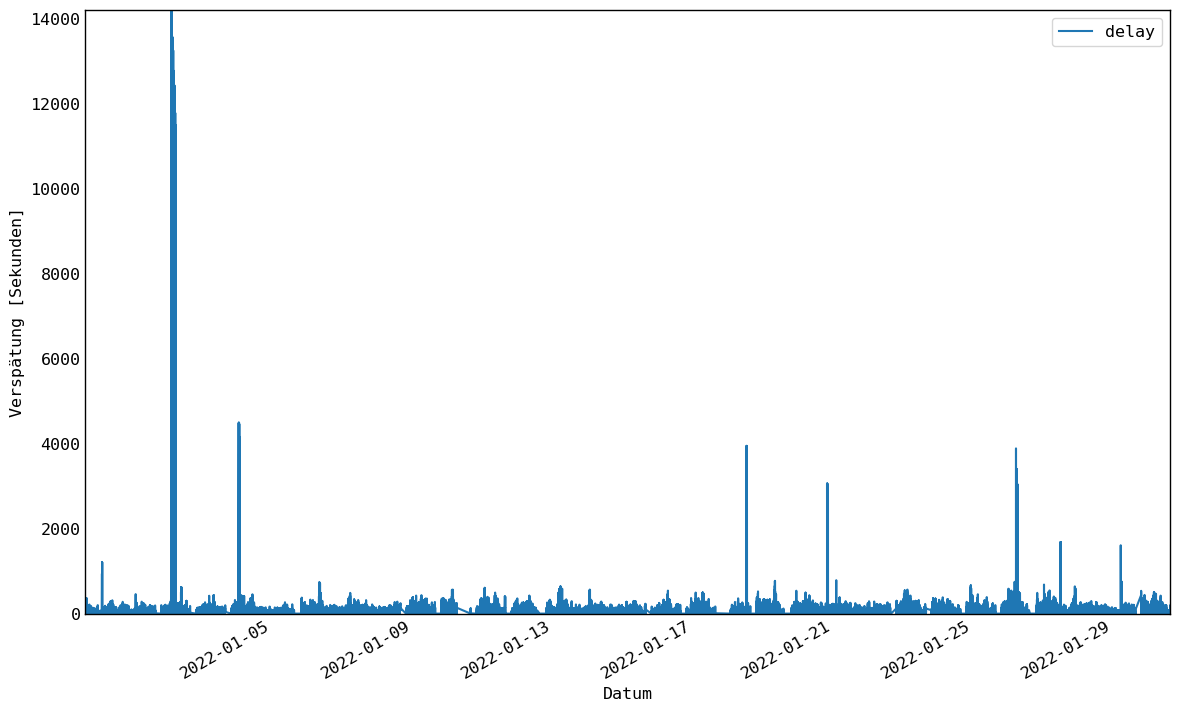

In [31]:
plt.figure(figsize = (14,8))

plt.plot(train_df['planned_departure'],train_df['delay_in_seconds'] , label='delay' )


plt.xticks(rotation=30)

plt.xlabel('Datum')
plt.ylabel('Verspätung [Sekunden]')

pass

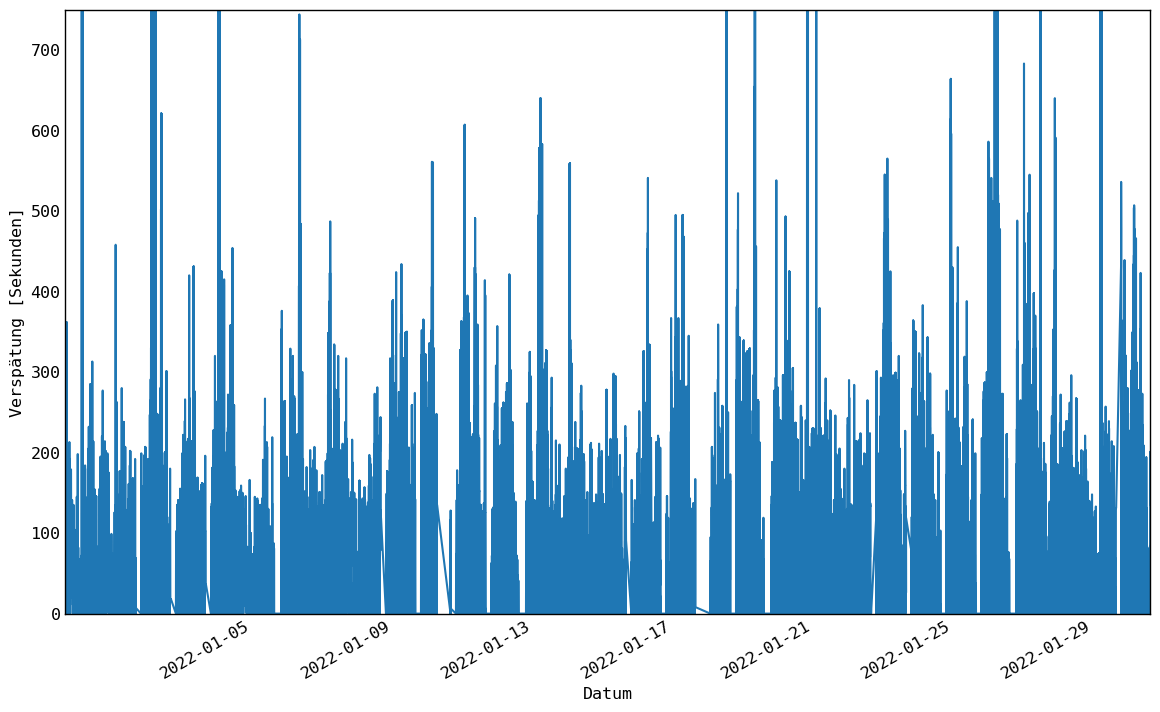

In [118]:
plt.figure(figsize = (14,8))

plt.plot(train_df['planned_departure'],train_df['delay_in_seconds'] , label='delay' )


plt.xticks(rotation=30)

plt.xlabel('Datum')
plt.ylabel('Verspätung [Sekunden]')

plt.ylim(0, 750)
pass

In [32]:

stats.describe(train_df['delay_in_seconds'])

DescribeResult(nobs=128217, minmax=(0.0, 14216.0), mean=55.56615737382718, variance=132050.45508415543, skewness=32.16165070534379, kurtosis=1118.9667172997592)

c:\Users\becci\AppData\Local\Continuum\anaconda3\lib\site-packages\july\rcmod.py:38: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  rcmod = ConfigDict(mpl.rcParams)


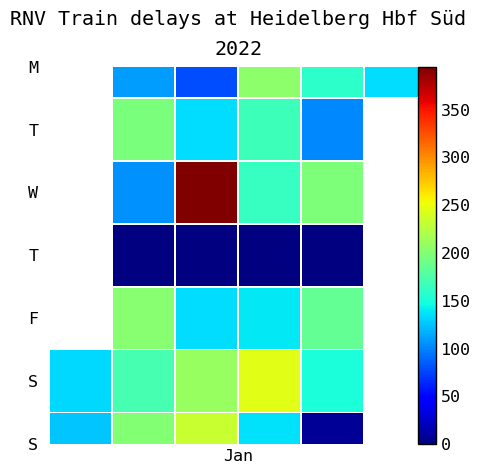

In [33]:
import numpy as np
import july
from july.utils import date_range

july.heatmap(
    train_df.planned_departure, # Here, osl_df is a pandas data frame.
    train_df.delay_in_seconds, 
    cmap="jet", 
    colorbar=True, 
    title="RNV Train delays at Heidelberg Hbf Süd"
)
pass


In [73]:
print(np.percentile(train_df['delay_in_seconds'], 90))
print(len(train_df[train_df['delay_in_seconds'] == 0])/len(train_df))
train_df_no_zero_delay = train_df[train_df.delay_in_seconds != 0]
print(np.percentile(train_df_no_zero_delay['delay_in_seconds'], 90))
print(np.percentile(train_df_no_zero_delay['delay_in_seconds'], 99))



133.0
0.5380643752388529
187.0
432.0


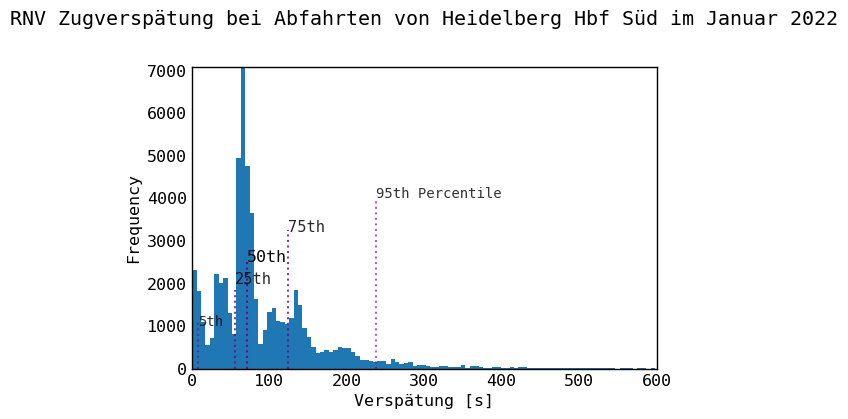

In [94]:
fig, ax = plt.subplots(figsize = (6,4))
df = train_df_no_zero_delay['delay_in_seconds']

df.plot(kind = "hist", density = False, bins = 2500) 

ax.set_xlabel("Verspätung [s]")


ax.set_xlim(0, 600)

ax.set_title("RNV Zugverspätung bei Abfahrten von Heidelberg Hbf Süd im Januar 2022")
quant_5, quant_25, quant_50, quant_75, quant_95 = df.quantile(0.05), df.quantile(0.25), df.quantile(0.5), df.quantile(0.75), df.quantile(0.95)

quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color='purple')

ax.text(quant_5-.1, 1000, "5th", size = 10, alpha = 0.8)
ax.text(quant_25-.13, 2000, "25th", size = 11, alpha = 0.85)
ax.text(quant_50-.13, 2500, "50th", size = 12, alpha = 1)
ax.text(quant_75-.13, 3200, "75th", size = 11, alpha = 0.85)
ax.text(quant_95-.25, 4000, "95th Percentile", size = 10, alpha =.8)

plt.show()

Now the weather dataset is analyzed

In [48]:
weather_df['timestamp_month'] = weather_df['timestamp'].dt.month
weather_df = weather_df[weather_df['timestamp_month'] == 1]


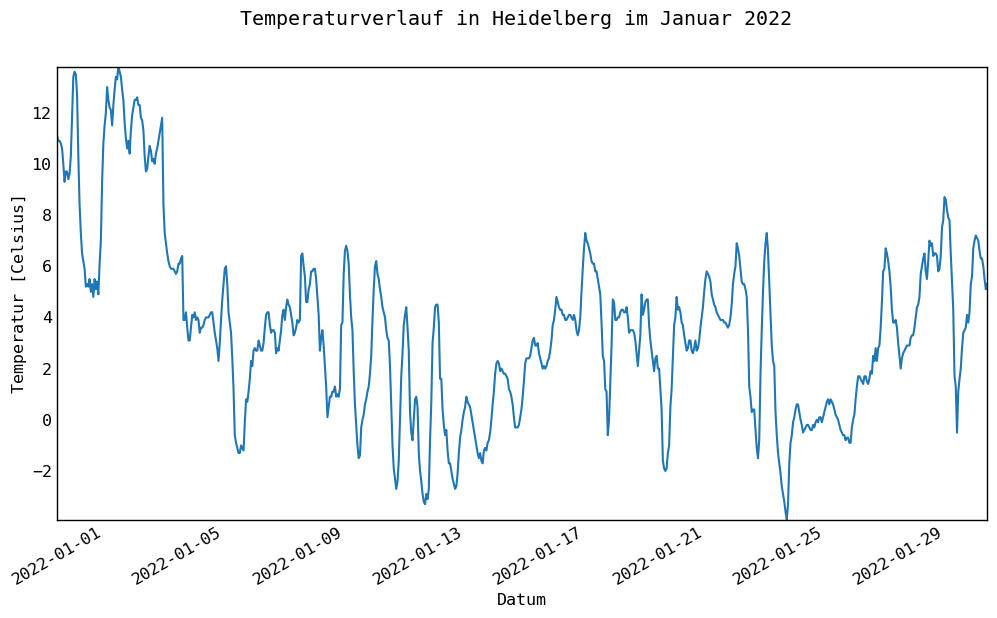

In [52]:
plt.figure(figsize = (12,6))
plt.plot(weather_df['timestamp'],weather_df['temperature'] , label='temperature' )


plt.xticks(rotation=30)

plt.xlabel('Datum')
plt.ylabel('Temperatur [Celsius]')
plt.title('Temperaturverlauf in Heidelberg im Januar 2022 ')
pass

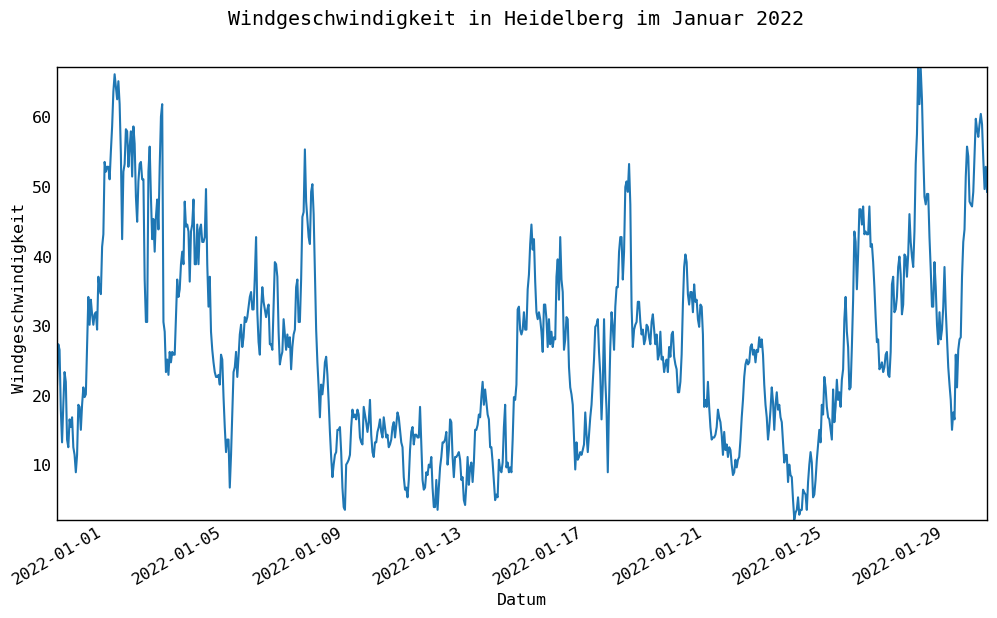

In [54]:
plt.figure(figsize = (12,6))
plt.plot(weather_df['timestamp'],weather_df['wind_speed'] , label='temperature' )


plt.xticks(rotation=30)

plt.xlabel('Datum')
plt.ylabel('Windgeschwindigkeit ')
plt.title('Windgeschwindigkeit in Heidelberg im Januar 2022 ')
pass

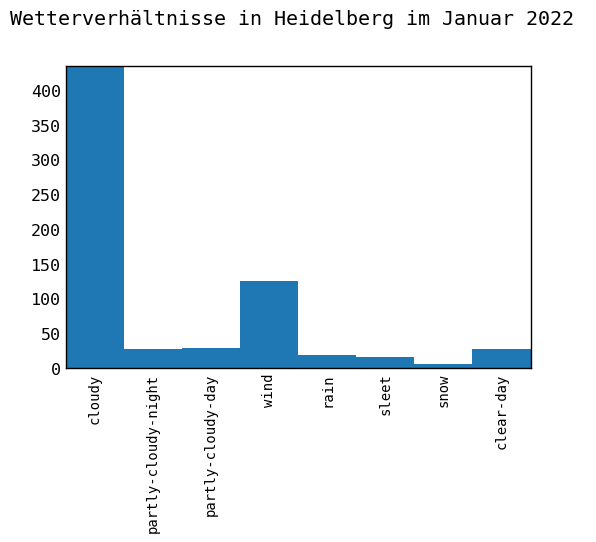

In [106]:
plt.hist(weather_df['icon'], bins=np.arange(9)-0.5)
plt.xticks(rotation=90, fontsize=10)
plt.title('Wetterverhältnisse in Heidelberg im Januar 2022 ')
pass

Now the train and weather data gets merged into one dataframe and correlations are studied.

In [107]:


weather_df['timestamp_hour'] = weather_df['timestamp'].dt.hour
weather_df['timestamp_day'] = weather_df['timestamp'].dt.day

blub = train_df.groupby(['planned_departure_day', 'planned_departure_hour'] , as_index=False)['delay_in_seconds'].sum()


merged_df = blub.merge(weather_df, left_on=[ 'planned_departure_day', 'planned_departure_hour'], right_on=[ 'timestamp_day', 'timestamp_hour'])


c:\Users\becci\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\becci\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [115]:

print(merged_df['delay_in_seconds'].corr(merged_df['temperature']))
print(merged_df['delay_in_seconds'].corr(merged_df['wind_speed']))
print(merged_df['delay_in_seconds'].corr(merged_df['pressure_msl']))
print(merged_df['delay_in_seconds'].corr(merged_df['wind_direction']))
print(merged_df['delay_in_seconds'].corr(merged_df['cloud_cover']))
print(merged_df['delay_in_seconds'].corr(merged_df['relative_humidity']))



0.12108847514269996
0.13164864848247942
-0.040685443256063346
0.030305726366271494
0.022222451617304496
-0.1127635492222691


Weather and train delays are not correlated